<a href="https://colab.research.google.com/github/choibumku00/Hands-on-GNN/blob/main/code/chapter11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Graphs using Graph Neural Networks

In [2]:
import torch
!pip install -q torch-scatter~=2.1.0 torch-sparse~=0.6.16 torch-cluster~=1.6.0 torch-spline-conv~=1.2.1 torch-geometric==2.2.0 -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install --pre deepchem

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 57.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 932.1/932.1 kB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.0/565.0 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 9.9 MB/s eta 0:00:00


## Traditional techniques

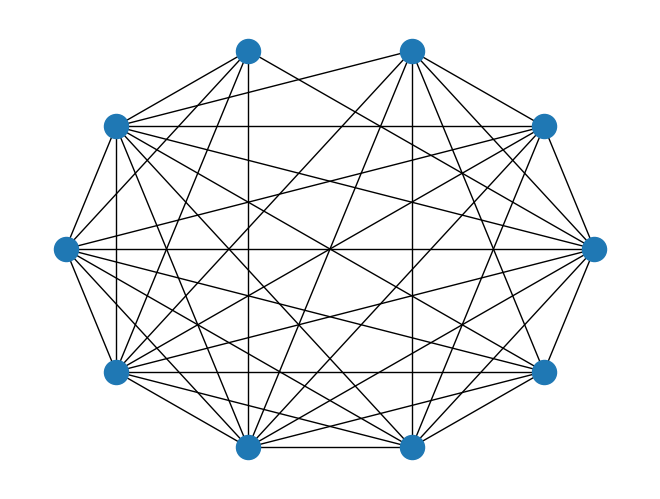

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Erdős-Rényi 그래프 G 생성
G = nx.erdos_renyi_graph(10, 0.9, seed=0) # 노드 수n=10 , 연결 확률p=0.9
pos = nx.circular_layout(G)
nx.draw(G, pos=pos)

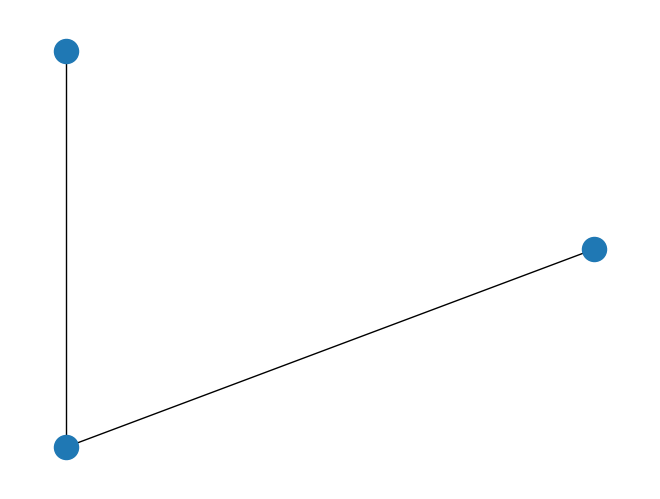

In [3]:
G = nx.gnm_random_graph(3, 2, seed=3) # 노드 수n=3, 그래프에 추가할 에지의 수M=2
pos = nx.circular_layout(G)
nx.draw(G, pos=pos)

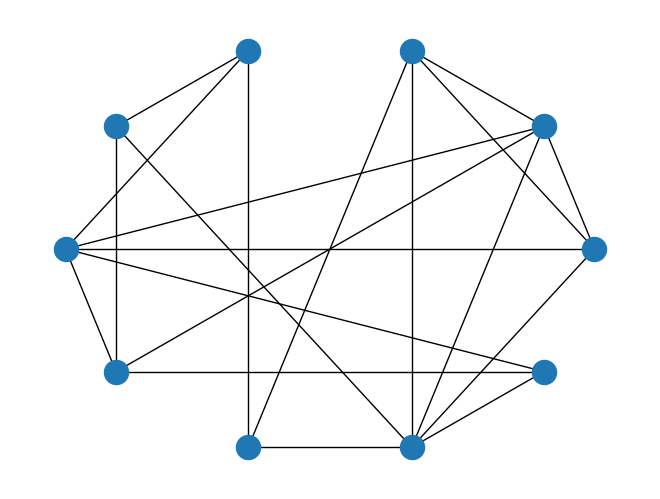

In [4]:
G = nx.watts_strogatz_graph(10, 4, 0.5, seed=0) #노드 수n=10, 각 노드에 연결된 초기 이웃 수k=4, 재배선 확률p=0.5
pos = nx.circular_layout(G)
nx.draw(G, pos=pos)

## Graph Variational Autoencoders (GVAE)

In [4]:
import torch
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True, split_labels=True, add_negative_train_samples=False),
])

dataset = Planetoid('.', name='Cora', transform=transform)

train_data, val_data, test_data = dataset[0]

Processing...
Done!


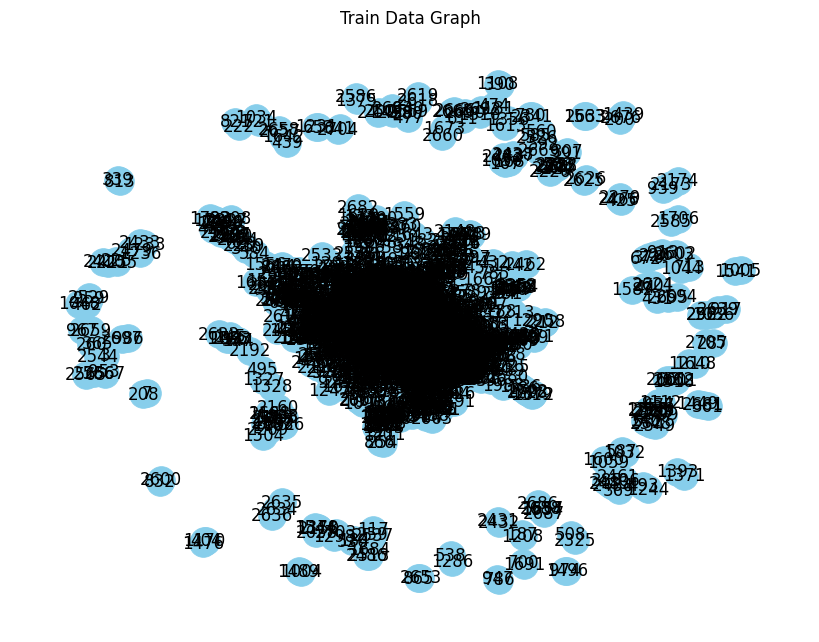

In [25]:
# train_data의 그래프 정보 가져오기
edge_index = train_data.edge_index
edges = edge_index.t().tolist()

# 그래프 생성
G = nx.Graph(edges)

# 그래프 시각화
plt.figure(figsize=(8, 6))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=400, edge_color='gray', linewidths=0.5)
plt.title("Train Data Graph")
plt.show()

In [6]:
from torch_geometric.nn import GCNConv, VGAE

class Encoder(torch.nn.Module):
    def __init__(self, dim_in, dim_out):
        super().__init__()
        self.conv1 = GCNConv(dim_in, 2 * dim_out)
        self.conv_mu = GCNConv(2 * dim_out, dim_out)
        self.conv_logstd = GCNConv(2 * dim_out, dim_out)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

model = VGAE(Encoder(dataset.num_features, 16)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index) # latent variables z 생성
    #reconstruction loss와 KL divergence를 계산한 최종 loss
    loss = model.recon_loss(z, train_data.pos_edge_label_index) + (1 / train_data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    return model.test(z, data.pos_edge_label_index, data.neg_edge_label_index)

for epoch in range(301):
    loss = train()
    val_auc, val_ap = test(val_data)
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:>3} | Val AUC: {val_auc:.4f} | Val AP: {val_ap:.4f}')

val_auc, val_ap = test(val_data)
print(f'\nTest AUC: {val_auc:.4f} | Test AP: {val_ap:.4f}')

Epoch:   0 | Val AUC: 0.6407 | Val AP: 0.6679
Epoch:  50 | Val AUC: 0.6380 | Val AP: 0.6625
Epoch: 100 | Val AUC: 0.7637 | Val AP: 0.7670
Epoch: 150 | Val AUC: 0.8461 | Val AP: 0.8518
Epoch: 200 | Val AUC: 0.8680 | Val AP: 0.8699
Epoch: 250 | Val AUC: 0.8800 | Val AP: 0.8844
Epoch: 300 | Val AUC: 0.9071 | Val AP: 0.9115

Test AUC: 0.9071 | Test AP: 0.9115


In [7]:
z = model.encode(test_data.x, test_data.edge_index)
# 잠재 벡터를 이용하여 유사도를 계산하고, 이 유사도가 임계값(0.9)을 넘는 경우에만 노드 간 연결
adj = torch.where((z @ z.T) > 0.9, 1, 0)
adj

tensor([[1, 1, 1,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 0, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [1, 1, 1,  ..., 0, 1, 1],
        [1, 1, 1,  ..., 0, 1, 1]], device='cuda:0')

## MolGAN

In [5]:
import pandas as pd
import numpy as np
from tensorflow import one_hot

import deepchem as dc
from deepchem.models.optimizers import ExponentialDecay
from deepchem.models import BasicMolGANModel as MolGAN
from deepchem.feat.molecule_featurizers.molgan_featurizer import GraphMatrix

from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdmolfiles
from rdkit.Chem import rdmolops
from rdkit.Chem.Draw import IPythonConsole

Error: Unable to import pysam. Please make sure it is installed.


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Error: Unable to import pysam. Please make sure it is installed.
Error: Unable to import pysam. Please make sure it is installed.


In [6]:
_, datasets, _ = dc.molnet.load_tox21()
df = pd.DataFrame(datasets[0].ids, columns=['smiles']) # smiles는 분자구조 표기법
df

[15:42:28] WARNING: not removing hydrogen atom without neighbors
[15:42:45] WARNING: not removing hydrogen atom without neighbors


,smiles
0,CC(O)(P(=O)(O)O)P(=O)(O)O
1,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C
2,OC[C@H](O)[C@@H](O)[C@H](O)CO
3,CCCCCCCC(=O)[O-].CCCCCCCC(=O)[O-].[Zn+2]
4,CC(C)COC(=O)C(C)C
...,...
6259,CC1CCCCN1CCCOC(=O)c1ccc(OC2CCCCC2)cc1
6260,Cc1cc(CCCOc2c(C)cc(-c3noc(C(F)(F)F)n3)cc2C)on1
6261,O=C1OC(OC(=O)c2cccnc2Nc2cccc(C(F)(F)F)c2)c2ccc...
6262,CC(=O)C1(C)CC2=C(CCCC2(C)C)CC1C


In [7]:
max_atom = 15 # 최대 원자 수를 15개

# smiles 문자열을 입력 특성으로 변환
featurizer = dc.feat.MolGanFeaturizer(max_atom_count=max_atom)
molecules = [x for x in df['smiles'].values if Chem.MolFromSmiles(x).GetNumAtoms() < max_atom]

# 유효하지 않은 특성 벡터를 가진 데이터는 주의가 뜸
features = []
for x in molecules:
    mol = Chem.MolFromSmiles(x)
    new_order = rdmolfiles.CanonicalRankAtoms(mol)
    mol = rdmolops.RenumberAtoms(mol, new_order)
    feature = featurizer.featurize(mol)
    if feature.size != 0:
        features.append(feature[0])

[15:42:54] WARNING: not removing hydrogen atom without neighbors
[15:42:56] WARNING: not removing hydrogen atom without neighbors


In [8]:
# 유효하지 않은 분자 특성 벡터를 제거
features = [x for x in features if type(x) is GraphMatrix]

In [9]:
len(features)

2107

In [10]:
# Create MolGAN
# 초기 학습률 0.001, 5000 epoch 마다 0.9를 곱하여 학습률을 업데이트
gan = MolGAN(learning_rate=ExponentialDecay(0.001, 0.9, 5000), vertices=max_atom)

# Create dataset
# 입력과 출력으로 나누어 데이터셋 생성
dataset = dc.data.NumpyDataset(X=[x.adjacency_matrix for x in features], y=[x.node_features for x in features])
dataset

<NumpyDataset X.shape: (2107, 15, 15), y.shape: (2107, 15), w.shape: (2107, 1), task_names: [ 0  1  2 ... 12 13 14]>

In [11]:
def iterbatches(epochs):
    for i in range(epochs):
        for batch in dataset.iterbatches(batch_size=gan.batch_size, pad_batches=True):
            # 미니배치의 인접 행렬과 노드 특성을 one-hot 인코딩
            adjacency_tensor = one_hot(batch[0], gan.edges)
            node_tensor = one_hot(batch[1], gan.nodes)
            yield {gan.data_inputs[0]: adjacency_tensor, gan.data_inputs[1]: node_tensor}

In [12]:
# Train model
# 생성자가 한 번 업데이트되는 횟수를 판별자가 업데이트되는 횟수의 0.2배로 설정
gan.fit_gan(iterbatches(25), generator_steps=0.2, checkpoint_interval=5000)

Ending global_step 549: generator average loss -1.69665, discriminator average loss -28.0399
TIMING: model fitting took 80.760 s


In [13]:
# Generate 1000 samples
generated_data = gan.predict_gan_generator(1000)
generated_mols = featurizer.defeaturize(generated_data) # 생성된 분자 데이터를 MolGanFeaturizer를 사용하여 분자로 변환

Generating 1000 samples


[15:44:37] Explicit valence for atom # 0 F, 40, is greater than permitted
[15:44:37] Explicit valence for atom # 0 F, 41, is greater than permitted
[15:44:37] Explicit valence for atom # 0 F, 41, is greater than permitted
[15:44:37] Explicit valence for atom # 0 F, 38, is greater than permitted
[15:44:37] Explicit valence for atom # 0 F, 39, is greater than permitted
[15:44:37] Explicit valence for atom # 9 C, 5, is greater than permitted
[15:44:37] Explicit valence for atom # 0 F, 40, is greater than permitted
[15:44:37] Explicit valence for atom # 0 F, 40, is greater than permitted
[15:44:37] Explicit valence for atom # 1 F, 35, is greater than permitted
[15:44:37] Explicit valence for atom # 0 F, 39, is greater than permitted
[15:44:37] Explicit valence for atom # 9 C, 5, is greater than permitted
[15:44:37] Explicit valence for atom # 9 C, 5, is greater than permitted
[15:44:37] Explicit valence for atom # 9 C, 6, is greater than permitted
[15:44:37] Explicit valence for atom # 0 F

In [14]:
# Check molecule validity (unstable so you might end up with 0 valid molecules)
valid_mols = [x for x in generated_mols if x is not None]
print (f'{len(valid_mols)} valid molecules (out of {len((generated_mols))} generated molecules)')

672 valid molecules (out of 1000 generated molecules)


In [15]:
generated_smiles = [Chem.MolToSmiles(x) for x in valid_mols]
generated_smiles_viz = [Chem.MolFromSmiles(x) for x in set(generated_smiles)]
print(f'{len(generated_smiles_viz)} unique valid molecules ({len(generated_smiles)-len(generated_smiles_viz)} redundant molecules)')

5 unique valid molecules (667 redundant molecules)


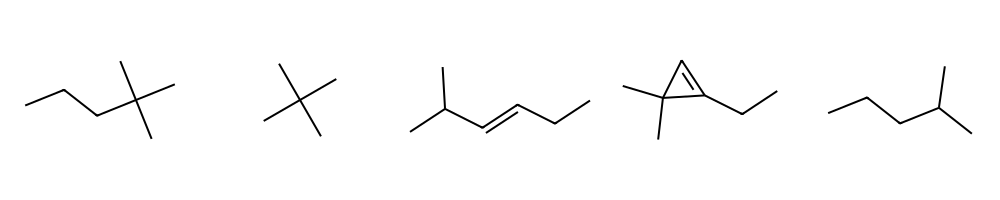

In [16]:
# 분자 객체들을 그리드 이미지로 변환
# 오류가 뜬다면 생성된 분자 구조가 없는 것, 다시 gan_fit 하기
Draw.MolsToGridImage(generated_smiles_viz, molsPerRow=5, subImgSize=(200, 200), returnPNG=False)